In [3]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score , ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from sklearn import metrics

%matplotlib inline

# Load the Data

In [6]:
df = pd.read_csv(r"C:\Users\almal\Desktop\cleaned_dataset_B.csv")  # Using the cleaned dataset from the EDA stage without outlier removal.
# The goal is to check if removing the outliers caused the model to overfit during training.

# Preprocess the Data

In [9]:
# Drop the 'position_encoded' column because there is another column with the same meaning
df.drop(['position_encoded'], axis=1, inplace=True)

# Keeping the original 'position' column intact for further encoding steps

In [11]:
df

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,winger
0,Manchester United,Goalkeeper,189.000000,32.0,104,0.000000,0.000000,0.009585,0.0,0.000000,1.217252,0.335463,9390,42,5,13,15000000,70000000,0
1,Manchester United,Goalkeeper,196.000000,30.0,15,0.000000,0.000000,0.069018,0.0,0.000000,1.242331,0.207055,1304,510,58,1,1500000,22000000,0
2,Manchester United,Goalkeeper,188.000000,37.0,4,0.000000,0.000000,0.000000,0.0,0.000000,0.616438,0.924658,292,697,84,4,600000,6000000,0
3,Manchester United,Defender Centre-Back,175.000000,25.0,82,0.028090,0.056180,0.224719,0.0,0.000000,0.000000,0.000000,6408,175,22,9,50000000,50000000,0
4,Manchester United,Defender Centre-Back,191.000000,30.0,63,0.017889,0.017889,0.053667,0.0,0.000000,0.000000,0.000000,5031,238,51,21,40000000,80000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10749,Western Sydney Wanderers,Attack-RightWinger,181.240353,20.0,16,0.175953,0.087977,0.263930,0.0,0.000000,0.000000,0.000000,1023,0,0,0,75000,75000,1
10750,Western Sydney Wanderers,Attack Centre-Forward,190.000000,24.0,26,0.372671,0.186335,0.186335,0.0,0.000000,0.000000,0.000000,1449,102,18,0,300000,300000,0
10751,Western Sydney Wanderers,Attack Centre-Forward,181.240353,19.0,20,0.375000,0.000000,0.187500,0.0,0.000000,0.000000,0.000000,960,0,0,0,50000,50000,0
10752,Western Sydney Wanderers,Attack Centre-Forward,181.240353,20.0,17,0.312139,0.104046,0.000000,0.0,0.104046,0.000000,0.000000,865,0,0,0,50000,50000,0


In [13]:
# Split all features into categorical and numeric
categorical_features = ['team','position']
numeric_features = ['height' , 'age','appearance','goals','assists','yellow cards','second yellow cards','red cards','goals conceded','clean sheets','minutes played','days_injured','games_injured',
                    'award','current_value','highest_value','winger']

In [15]:
# one hot encoding for categorical_features
df = pd.get_dummies(df, columns = categorical_features, drop_first=True)

In [17]:
df.shape

(10754, 405)

In [19]:
p33 = df['current_value'].quantile(0.33)  # Lower than 33rd percentile
p66 = df['current_value'].quantile(0.66)  # Medium: Between 33rd and 66th percentile



def categorize_values(value):
    if value <= p33:
        return 'Low'
    elif p33 < value <= p66:
        return 'Medium'
    else:
        return 'High'

# Apply the function to create a new column
df['current_value_category'] = df['current_value'].apply(categorize_values)

df.drop('current_value', axis=1, inplace=True)

In [21]:
df[['current_value_category']]

,current_value_category
0,High
1,Medium
2,Medium
3,High
4,High
...,...
10749,Low
10750,Low
10751,Low
10752,Low


In [23]:
df['current_value_category'].value_counts()

current_value_category
Low       3725
High      3536
Medium    3493
Name: count, dtype: int64

In [25]:
encoder = LabelEncoder()
df['current_value_category_encoded'] = encoder.fit_transform(df['current_value_category']) 

# Feature selection

In [28]:
correlation = df.corr(numeric_only=True)
print(correlation['current_value_category_encoded'].sort_values(ascending=False))

current_value_category_encoded    1.000000
age                               0.090256
team_Querétaro FC                 0.046216
team_FC Pari Nizhniy Novgorod     0.044743
team_Orlando Pirates              0.043945
                                    ...   
games_injured                    -0.101015
award                            -0.152961
minutes played                   -0.277696
appearance                       -0.291350
highest_value                    -0.395944
Name: current_value_category_encoded, Length: 405, dtype: float64


In [29]:
threshold = 0.07 

selected_features = correlation[abs(correlation['current_value_category_encoded']) > threshold]['current_value_category_encoded'].index
selected_features

Index(['age', 'appearance', 'assists', 'minutes played', 'days_injured',
       'games_injured', 'award', 'highest_value',
       'current_value_category_encoded'],
      dtype='object')

In [30]:
df.drop('current_value_category', axis=1, inplace=True)

In [31]:
selected_features = ['age', 'appearance', 'assists', 'minutes played', 'days_injured',
       'games_injured', 'award', 'highest_value',
       'current_value_category_encoded']

In [36]:
df = df[selected_features]
df.head()

,age,appearance,assists,minutes played,days_injured,games_injured,award,highest_value,current_value_category_encoded
0,32.0,104,0.000000,9390,42,5,13,70000000,0
1,30.0,15,0.000000,1304,510,58,1,22000000,2
2,37.0,4,0.000000,292,697,84,4,6000000,2
3,25.0,82,0.056180,6408,175,22,9,50000000,0
4,30.0,63,0.017889,5031,238,51,21,80000000,0


In [38]:
# Prepare data
X = df.drop(['current_value_category_encoded'], axis=1)
y = df['current_value_category_encoded']


# Split data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
X.shape

(10754, 8)

# Build both Models (DT and RF)

In [43]:
dt_classifier = DecisionTreeClassifier()
rf_classifier = RandomForestClassifier()

In [45]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 10, 15,17],   # Regularization strength
    'n_estimators':[35, 40, 50, 60, 70, 80, 90]
}
grid_search = GridSearchCV(estimator=rf_classifier,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

# Train both Models (DT and RF)

In [48]:
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [50]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [51]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 10, 15, 17],
                         'n_estimators': [35, 40, 50, 60, 70, 80, 90]},
             scoring='f1_macro', verbose=1)

In [54]:
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 35}

In [56]:
best_model = grid_search.best_estimator_

# Test both Models (DT and RF)

In [59]:
y_pred_dt = dt_classifier.predict(X_test)
y_pred_rf = rf_classifier.predict(X_test)
y_pred_rf_g = best_model.predict(X_test)

# Evaluating Decision Tree model

In [62]:
# our benchmark model
base_model = round(df['current_value_category_encoded'].value_counts()[1]/df.shape[0]*100, 2)
base_model

34.64

In [64]:
accuracy = accuracy_score(y_test, y_pred_dt)
accuracy
# The Decision Tree achieved an accuracy of 0.81 on the test set.

0.8196187819618782

In [66]:
y_pred_train_dt = dt_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train_dt)
accuracy
# There is overfitting.

1.0

In [68]:
# Calculate Precision
precision = precision_score(y_test, y_pred_dt, average='macro')
precision

0.8199320145895131

In [70]:
# Calculate Recall
recall = recall_score(y_test, y_pred_dt, average='macro')
recall

0.8206411015746761

In [72]:
# Calculate F1 score
f1 = f1_score(y_test, y_pred_dt, average='macro')
f1

0.8202238943342488

In [74]:
# Confusion matrix for Random Forest best model
conf_matrix = confusion_matrix(y_test, y_pred_dt)
conf_matrix

array([[577,   8,  83],
       [  7, 647,  95],
       [ 86, 109, 539]], dtype=int64)

In [76]:
# Evaluating results for the Random Forest best model
print(classification_report(y_test,
                      y_pred_dt,
                      labels=list(best_model.classes_)))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       668
           1       0.85      0.86      0.86       749
           2       0.75      0.73      0.74       734

    accuracy                           0.82      2151
   macro avg       0.82      0.82      0.82      2151
weighted avg       0.82      0.82      0.82      2151



# Evaluating Random Forest model

In [79]:
accuracy = accuracy_score(y_test, y_pred_rf)
accuracy
# The Random Forest achieved an accuracy of 0.85 on the test set, which is 5% higher than the Decision Tree.

0.8665736866573687

In [81]:
y_pred_train_rf = rf_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train_rf)
accuracy
# There is overfitting.

1.0

In [118]:
# It seems like there is overfitting, as the model achieves 1.0 accuracy on the training set using Dt and RF while on testing achieved 0.81 and 0.86

In [85]:
# Calculate Precision
precision = precision_score(y_test, y_pred_rf, average='macro')
precision

0.869953920083662

In [87]:
# Calculate Recall
recall = recall_score(y_test, y_pred_rf, average='macro')
recall

0.8691497165591402

In [89]:
# Calculate F1 score
f1 = f1_score(y_test, y_pred_rf, average='macro')
f1

0.8678130824257577

In [91]:
# Confusion matrix for Random Forest
conf_matrix = confusion_matrix(y_test, y_pred_rf)
conf_matrix

array([[631,   0,  37],
       [  9, 623, 117],
       [ 85,  39, 610]], dtype=int64)

In [93]:
# Evaluating results for the Random Forest best model
print(classification_report(y_test,
                      y_pred_rf,
                      labels=list(best_model.classes_)))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91       668
           1       0.94      0.83      0.88       749
           2       0.80      0.83      0.81       734

    accuracy                           0.87      2151
   macro avg       0.87      0.87      0.87      2151
weighted avg       0.87      0.87      0.87      2151



# Evaluating Random Forest best model

In [96]:
accuracy = accuracy_score(y_test, y_pred_rf_g)
accuracy

0.8642491864249187

In [98]:
y_pred_train_rf_g = best_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train_rf_g)
accuracy

0.9240962454957573

In [116]:
# By using the best model for Random Forest, it appears that the overfitting reduced.

In [102]:
# Confusion matrix for Random Forest best model
conf_matrix = confusion_matrix(y_test, y_pred_rf_g)
conf_matrix

array([[638,   0,  30],
       [  6, 610, 133],
       [ 99,  24, 611]], dtype=int64)

In [104]:
# Evaluating results for the Random Forest best model
print(classification_report(y_test,
                      y_pred_rf_g,
                      labels=list(best_model.classes_)))

              precision    recall  f1-score   support

           0       0.86      0.96      0.90       668
           1       0.96      0.81      0.88       749
           2       0.79      0.83      0.81       734

    accuracy                           0.86      2151
   macro avg       0.87      0.87      0.87      2151
weighted avg       0.87      0.86      0.86      2151



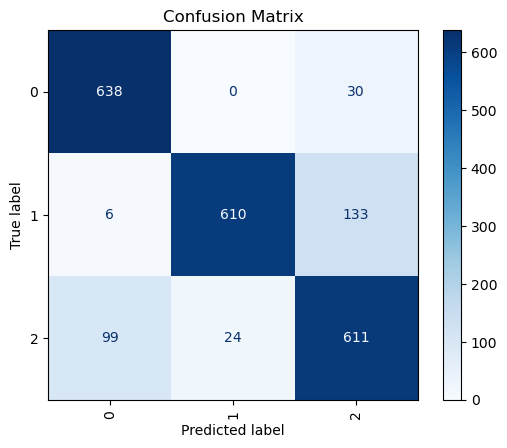

In [106]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_g,
                                        display_labels=best_model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [108]:
# Calculate Precision
precision = precision_score(y_test, y_pred_rf_g, average='macro')
precision

0.8700772726816107

In [110]:
# Calculate Recall
recall = recall_score(y_test, y_pred_rf_g, average='macro')
recall

0.8673113713711172

In [112]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred_rf_g, average='macro')
f1

0.865602759134788

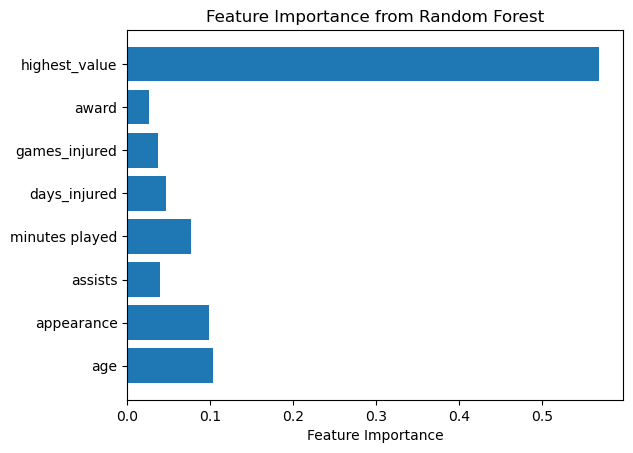

In [114]:
# Feature importance from Random Forest best model
feature_importances = best_model.feature_importances_
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.show()